<a href="https://colab.research.google.com/github/andrebelem/pythonverse/blob/main/Extra%C3%A7%C3%A3o_de_dados_de_Precipita%C3%A7%C3%A3o_no_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="display: flex; align-items: center;">
    <img src="http://observatoriooceanografico.org/wp-content/uploads/elementor/thumbs/logo-o2-2-p31vla9ib17i85olifd4l1xk0e5lktrkal6u0s4c6o.png" style="width: 100px;"/>
    <h1 style="margin-left: 20px;">Extração de dados de precipitação na nuvem do CESM-LENS (via AWS)</h1>
</div>


Criado por [A.L. Belém](mailto:andrebelem@id.uff.br) @ [Observatório Oceanográfico](http://www.observatoiriooceanografico.uff.br) 2024 (versão 1) <br>
Para maiores informações, acesse o [`pythonverse`](https://github.com/andrebelem/pythonverse) no meu github, e use a referência [![DOI](https://zenodo.org/badge/342919527.svg)](https://zenodo.org/badge/latestdoi/342919527)

###### Última atualização: 09 de Maio de 2024.

O objetivo deste notebook é "extrair" dados do CESM-LENS na nuvem do NCAR na Amazon, sobre o Rio Grande do Sul, especificamente dados de precipitação diária máxima e precipitação diária, para os períodos "histórico", "20th Century" e o cenário do IPCC "RPC8.5". Mais detalhes sobre essa versão, procure os documentos no https://github.com/NCAR/cesm-lens-aws<br>

**Note** que ao final eu gravo os resultados em uma área do meu google drive, e portanto, estou montando o gdrive no meu google colab antes de iniciar.

O primeiro passo é a instalação de praticamente tudo que vou precisar aqui (abaixo).

In [1]:
# instalando o módulo para trabalhar com o bucket do AWS e mais algumas atualizações necessárias
# note que dependendo das versões do COLAB, isso pode ser alterado. Vale a pena verificar a necessidade de
# reinstalação do xarray completo (neste caso, para permitir flexibilidade com o cftime)
%%capture
!pip install s3fs
!pip install Intake-esm
!pip install -U xarray[complete] # reinstala todo o xarray (útil nessa versão do colab por conta do cftime)

!pip install salem  # e também com o salem e o rasterio
!pip install rasterio

!pip install cartopy # porque queremos fazer mapas legais.
# provavelmente o seu runtime irá reiniciar. Não tem problema ! É normal isso acontecer.

In [ ]:
# esta linha é necessária por conta de algumas atualizações. Talvez em um futuro seja desnecessário.
!pip install pandas>=2.1.0 # uma pequena atualização também por conta do bucket da AWS

Agora, o segundo passo é baixar os shapes das UGRHs que estão no meu github, mas podem ser obtidas no site da [ANA](https://metadados.snirh.gov.br/geonetwork/srv/eng/catalog.search#/metadata/985f8821-2da3-4108-85a9-95985b37f3fe).

In [3]:
!wget https://github.com/andrebelem/pythonverse/raw/main/datasets/SNIRH_UGRHs_2020.zip

--2024-05-09 18:19:48--  https://github.com/andrebelem/pythonverse/raw/main/datasets/SNIRH_UGRHs_2020.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/andrebelem/pythonverse/main/datasets/SNIRH_UGRHs_2020.zip [following]
--2024-05-09 18:19:48--  https://media.githubusercontent.com/media/andrebelem/pythonverse/main/datasets/SNIRH_UGRHs_2020.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13113509 (13M) [application/zip]
Saving to: ‘SNIRH_UGRHs_2020.zip’

SNIRH_UGRHs_2020.zi 100%[===================>]  12.51M  --.-KB/s    in 0.1s    

2024-05-09 18:19:49 (113 MB/s) - ‘SNIRH_

In [4]:
# vamos explorar esse arquivo e separar as UGRHs que compõem o RS, ou seja,
# apenas aquelas que estão abaixo de 26°S de latitude

import geopandas as gpd
ugrh = gpd.read_file('SNIRH_UGRHs_2020.zip')

rs = ugrh[ugrh.bounds['maxy'] < -26]
# para facilitar a extração:
sul_ugrh = rs.dissolve()
print(f'Bounds:{sul_ugrh.bounds}')

Bounds:        minx       miny       maxx       maxy
0 -57.643885 -33.752081 -49.280653 -26.241184


Agora que temos um shapefile para recortar, vamos obter os dados do CESM-LENS.

## CESM-LENS na nuvem (AWS S3)

Aqui vou obter os campos do CESM-Large Ensemble para os experimentos "20C" (ou 20 century: 1920 à 2005) e "HIST" que é período histórico de 1850-1920, além do cenário RCP8.5. Veja abaixo que estou interessado apenas na precipitação máxima (ou na precipitação diária, dependendo do dataset). Note ainda que o procedimento aqui é para separar os datasets e grava-los em netcdf, já que são campos muito grandes e os "chunks" de tempo demoram muito para serem executados. Obviamente eu já poderia fazer toda a análise aqui, mas preferi primeiro extrair, para depois processar em outro notebook. Você pode fazer o mesmo para qualquer variável.

**Detalhe importante**: Como reinstalamos o xarray, ele não reconhece de primeira o arquivo METADATA. Note então que tenho que rodar a célula abaixo 2x (!)

In [6]:
# de alguma forma, o python não reconhece em uma primeira rodada o arquivo METADATA.
# Rode 2x essa célula !
import intake
col = intake.open_esm_datastore("https://raw.githubusercontent.com/NCAR/cesm-lens-aws/main/intake-catalogs/aws-cesm1-le.json")

In [8]:
# estou interessado na variável que contém a "taxa de precipitação". vou listar todas as opções aqui
col.df[(col.df['long_name'].str.contains('precipitation rate', na=False))&(col.df['variable']=='PRECTMX')]

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
12,PRECTMX,maximum (convective and large-scale) precipita...,atm,20C,daily,1.0,global,m/s,1920-01-01 12:00:00,2005-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-20C-PRECT...
54,PRECTMX,maximum (convective and large-scale) precipita...,atm,HIST,daily,1.0,global,m/s,1850-01-01 12:00:00,1919-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-HIST-PREC...


In [11]:
# e o mesmo para o experimento RCP8.5
col.df[(col.df['long_name'].str.contains('precipitation rate', na=False))&(col.df['experiment'].str.contains('RCP'))]

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
74,PRECL,large-scale (stable) precipitation rate (liq +...,atm,RCP85,daily,1.0,global,m/s,2006-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-RCP85-PRE...
77,PRECT,total (convective and large-scale) precipitati...,atm,RCP85,daily,1.0,global,m/s,2006-01-01 12:00:00,2100-12-31 12:00:00,s3://ncar-cesm-lens/atm/daily/cesmLE-RCP85-PRE...
100,PRECT,total (convective and large-scale) precipitati...,atm,RCP85,hourly6-2026-2035,1.0,global,m/s,2026-01-01 00:00:00,2036-01-01 00:00:00,s3://ncar-cesm-lens/atm/hourly6-2026-2035/cesm...
113,PRECT,total (convective and large-scale) precipitati...,atm,RCP85,hourly6-2071-2080,1.0,global,m/s,2071-01-01 00:00:00,2081-01-01 00:00:00,s3://ncar-cesm-lens/atm/hourly6-2071-2080/cesm...
205,PRECC,convective precipitation rate (liq + ice),atm,RCP85,monthly,1.0,global,m/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-P...
206,PRECL,large-scale (stable) precipitation rate (liq +...,atm,RCP85,monthly,1.0,global,m/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/atm/monthly/cesmLE-RCP85-P...


Note que há uma variável chamada PRECTMX que é o "maximum (convective and large-scale) precipitation rate". Já para os experimentos de RCP, vou usar a variável PRECT.

In [12]:
# vou fazer um subset onde separo apenas o que eu quero, frequência diária
col_subset = col.search(experiment=["HIST","20C"], frequency="daily", variable=["PRECTMX"])
col_subset2 = col.search(experiment=["RCP85"], frequency="daily", variable=["PRECT"])
# agora vou criar datasets do meu subset
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
dsets2 = col_subset2.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


In [14]:
# Apenas para verificar, os dados estão aqui:
print(dsets.keys(),dsets2.keys())

dict_keys(['atm.20C.daily', 'atm.HIST.daily']) dict_keys(['atm.RCP85.daily'])


In [15]:
# compatibiliza as longitudes entre o shape e o dataset com uma margem de 1 grau
lons = slice(sul_ugrh.bounds['minx'].values[0]+360-1, sul_ugrh.bounds['maxx'].values[0]+360+1)
lats = slice(sul_ugrh.bounds['miny'].values[0]-1, sul_ugrh.bounds['maxy'].values[0]+1)

# a minha estratégia aqui foi obter um campo um pouco maior do que os bounds do meu shapefile. No processamento isso será importante.

In [17]:
# extraindo o dataset de cada experimento dentro do que precisamos
# note que estou compatibilizando as longitudes entre o shape e o dataset
ds_hist = dsets['atm.HIST.daily'].sel(lon=lons,lat=lats)
ds_20C = dsets['atm.20C.daily'].sel(lon=lons,lat=lats)
ds_rcp85 = dsets2['atm.RCP85.daily'].sel(lon=lons,lat=lats)

In [18]:
# Converter as longitudes de 0-360 para -180 a +180
ds_20C['lon'] = ((ds_20C['lon'] + 180) % 360) - 180
ds_hist['lon'] = ((ds_hist['lon'] + 180) % 360) - 180
ds_rcp85['lon'] = ((ds_rcp85['lon'] + 180) % 360) - 180

In [22]:
# agora vamos passar tudo que já fizemos do dask para a memória. Isso pode demorar um pouco !
# ##### CAUTELA #### cada execução pode demorar aprox. 1h2-1h30
from dask.diagnostics import ProgressBar
ProgressBar().register()

O `Dask` é uma biblioteca Python projetada para processamento paralelo e distribuído de grandes conjuntos de dados. Quando você executa operações em um objeto `Xarray` com o backend `Dask`, como por exemplo, filtragem, agregação ou cálculos complexos, essas operações não são executadas imediatamente. Em vez disso, o `Dask` constrói um gráfico de tarefas que representa as operações a serem realizadas nos dados. É o que chamamos de "lazy evaluation", o que significa que as operações não são realizadas até que seja necessário obter o resultado final. Por um lado, isso é bom para trabalhar com grandes volumes de dados, mas se você está fazendo uma "exploração" de dados, essa demora pode prejudicar bastante o seu trabalho.

Quando você chama o método `.load()` em um objeto `Xarray` com o backend `Dask`, isso atua como um gatilho para iniciar a execução real das operações pendentes e carregar os resultados na memória. Ao chamar `.load()`, você instrui o `Dask` a realizar as operações necessárias para calcular o resultado e carregar os dados calculados na memória, convertendo-os em um objeto `Xarray` regular. Então, **você tem que ter certeza do que está fazendo**.

In [23]:
ds_20C.load() # executa para 20C

[########################################] | 100% Completed | 56m 8s


<xarray.Dataset> Size: 403MB
Dimensions:    (member_id: 40, time: 31390, lat: 10, lon: 8, nbnd: 2)
Coordinates:
  * lat        (lat) float64 80B -34.4 -33.46 -32.51 ... -27.8 -26.86 -25.92
  * lon        (lon) float64 64B -57.5 -56.25 -55.0 ... -51.25 -50.0 -48.75
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 251kB 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
    time_bnds  (time, nbnd) object 502kB 1920-01-01 00:00:00 ... 2006-01-01 0...
Dimensions without coordinates: nbnd
Data variables:
    PRECTMX    (member_id, time, lat, lon) float32 402MB 4.925e-08 ... 8.146e-08
Attributes: (12/25)
    Conventions:                       CF-1.0
    NCO:                               4.4.2
    Version:                           $Name$
    important_note:                    This data is part of the project 'Blin...
    initial_file:                      b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i....
    logname:                           mudryk
    ...                                ...
    intake_esm_attrs:units:            m/s
    intake_esm_attrs:start_time:       1920-01-01 12:00:00
    intake_esm_attrs:end_time:         2005-12-31 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/atm/daily/cesmLE-2...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.20C.daily

In [24]:
ds_hist.load() # executa para o hist (que é bem mais rápido pois é apenas 1 membro)

[########################################] | 100% Completed | 54.02 s


<xarray.Dataset> Size: 9MB
Dimensions:    (time: 25550, lat: 10, lon: 8, nbnd: 2)
Coordinates:
  * lat        (lat) float64 80B -34.4 -33.46 -32.51 ... -27.8 -26.86 -25.92
  * lon        (lon) float64 64B -57.5 -56.25 -55.0 ... -51.25 -50.0 -48.75
    member_id  int64 8B 1
  * time       (time) object 204kB 1850-01-01 12:00:00 ... 1919-12-31 12:00:00
    time_bnds  (time, nbnd) object 409kB 1850-01-01 00:00:00 ... 1920-01-01 0...
Dimensions without coordinates: nbnd
Data variables:
    PRECTMX    (time, lat, lon) float32 8MB 2.213e-13 1.322e-09 ... 1.831e-08
Attributes: (12/25)
    Conventions:                       CF-1.0
    NCO:                               4.4.2
    Version:                           $Name$
    important_note:                    This data is part of the project 'Blin...
    initial_file:                      b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i....
    logname:                           mudryk
    ...                                ...
    intake_esm_attrs:units:            m/s
    intake_esm_attrs:start_time:       1850-01-01 12:00:00
    intake_esm_attrs:end_time:         1919-12-31 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/atm/daily/cesmLE-H...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.HIST.daily

In [25]:
ds_rcp85.load() # executa para o rcp8.5 (que também é longo, com 105 membros)

[########################################] | 100% Completed | 58m 38s


<xarray.Dataset> Size: 445MB
Dimensions:    (member_id: 40, time: 34675, lat: 10, lon: 8, nbnd: 2)
Coordinates:
  * lat        (lat) float64 80B -34.4 -33.46 -32.51 ... -27.8 -26.86 -25.92
  * lon        (lon) float64 64B -57.5 -56.25 -55.0 ... -51.25 -50.0 -48.75
  * member_id  (member_id) int64 320B 1 2 3 4 5 6 7 ... 35 101 102 103 104 105
  * time       (time) object 277kB 2006-01-01 12:00:00 ... 2100-12-31 12:00:00
    time_bnds  (time, nbnd) object 555kB 2006-01-01 00:00:00 ... 2101-01-01 0...
Dimensions without coordinates: nbnd
Data variables:
    PRECT      (member_id, time, lat, lon) float32 444MB 2.779e-12 ... 3.297e-07
Attributes: (12/26)
    Conventions:                       CF-1.0
    NCO:                               4.4.2
    Version:                           $Name$
    host:                              tcs-f02n07
    important_note:                    This data is part of the project 'Blin...
    initial_file:                      b.e11.B20TRC5CNBDRD.f09_g16.105.cam.i....
    ...                                ...
    intake_esm_attrs:units:            m/s
    intake_esm_attrs:start_time:       2006-01-01 12:00:00
    intake_esm_attrs:end_time:         2100-12-31 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/atm/daily/cesmLE-R...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.RCP85.daily

In [26]:
# agora eu gravo todos os meus resultados em netcdf
ds_20C.to_netcdf('ds_20c.nc')
ds_hist.to_netcdf('ds_hist.nc')
ds_rcp85.to_netcdf('ds_rcp85.nc')

# e transfiro para minha área no google drive.
!mv *.nc /content/drive/MyDrive/01_Pesquisa/00_PrecipRS/.

# Alguns adicionais

Para deixar o processo um pouco mais interessante, vou produzir um mapa. Neste caso, vou fazer a média do máximo de precipitação entre todos os membros e todos os anos, <u>apenas para o mes de maio</u>, do dataset `20C`. Vou aproveitar também para converter as unidades para mm/dia.

In [35]:
# note que a unidade de medida desses campos são em m/s (fluxo de água)
# portanto, para converter em mm/dia eu vou usar a função abaixo
def mm_per_day(precip):
    ''' Esta função converte a precipitação dada em m/s para mm/dia (mais condizente com o que conhecemos de meteorologia)
        Basicamente, 1 metro = 1000 milimetros, e dia = 86400 segundos.
    '''
    return precip * 1000 * 86400

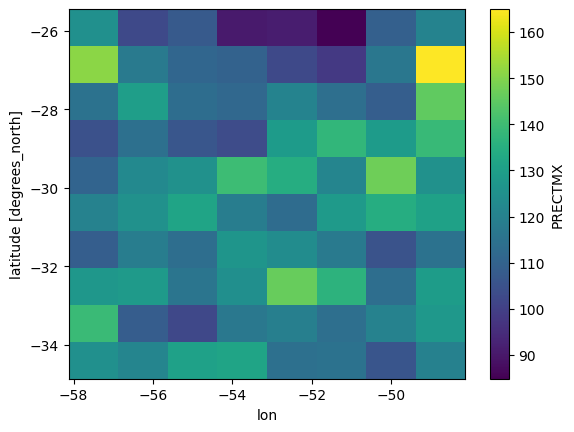

In [39]:
# construindo um campo apenas para fazer um plot
may_median = ds_20C.sel(time=ds_20C['time.month'] == 5).PRECTMX.max(dim=['time','member_id']).pipe(mm_per_day)
may_median.plot() # caso você queira ver como ficou

Aqui vou plotar um mapa decente, com escala de cores, que corresponde a precipitação máxima, entre todos os membros e todos os anos, para o mes de maio, entre 1920 e 2005 (dataset 20C) do CESM-LENS. Note que os valores não tem uma distribuição contínua, justamente porque este é um pseudo-*heatmap* e não uma medida essencialmente estatística.

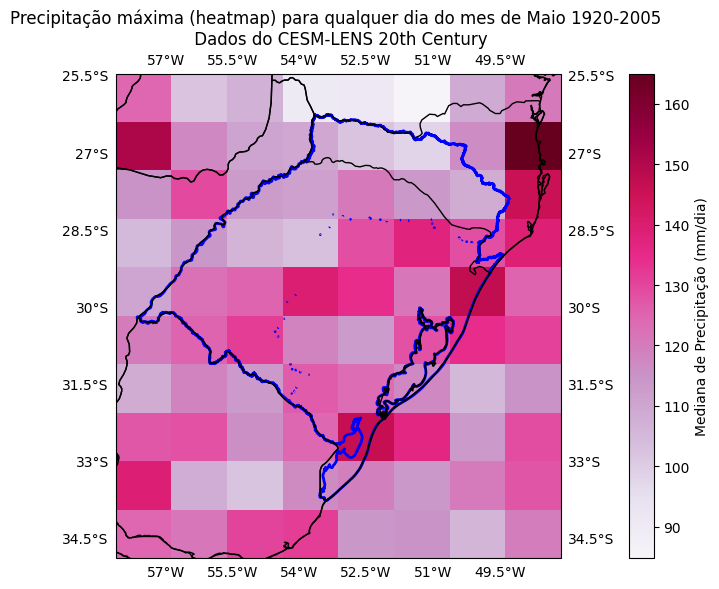

In [42]:
# Fazendo um plot "decente"
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())

plot = may_median.plot(ax=ax,
                transform=ccrs.PlateCarree(), x='lon', y='lat',
                cmap='PuRd',add_colorbar=False)
# título do plot
plt.title('Precipitação máxima (heatmap) para qualquer dia do mes de Maio 1920-2005 \n Dados do CESM-LENS 20th Century')
cbar = plt.colorbar(plot, ax=ax, orientation='vertical')
cbar.set_label('Mediana de Precipitação (mm/dia)')

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_lines')
contries = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_0_countries')

ax.add_feature(states, facecolor='none', edgecolor='black')
ax.add_feature(contries, facecolor='none', edgecolor='black')
ax.gridlines(draw_labels=True,crs=ccrs.PlateCarree(),x_inline=False,y_inline=False,color = "None")

# aqui plota o shapefile das UGRHs do sul.
sul_ugrh.geometry.plot(ax=ax,facecolor='none',edgecolor='blue',linewidth=2,label='Limite das UGRHs')

ax.coastlines()

plt.tight_layout()
plt.show()

Este é um excelente exemplo de como trabalhar com dados grandes na nuvem. O tempo total para rodar este notebook é basicamente condicionado pelo tempo dos `.load()`s dos datasets (aqui: >2h).

Boa sorte !

**PS**: Se você gostou, você pode [comprar um café para mim !](https://www.buymeacoffee.com/andrebelem)😉
